In [1]:
from IPython.display import clear_output
!pip install gdown==v4.6.3
!pip install ktrain==v0.39.0
clear_output()

In [2]:
import os
import pandas as pd
import numpy as np
import ktrain as kt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk

In [3]:
!gdown 1FJb76svNLLiuwNCuOjeLbjbXw81Fnt5y
df = pd.read_csv('2.1 - cgpt_labelled.csv', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1FJb76svNLLiuwNCuOjeLbjbXw81Fnt5y
To: /content/2.1 - cgpt_labelled.csv
100% 3.43M/3.43M [00:00<00:00, 21.5MB/s]


In [4]:
len(df)

25419

In [5]:
# cleaning from unwanted classes
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df = df[df["emotion_chatgpt"].isin(emotions)]

In [6]:
len(df)

25120

#### Clean up dialog in preparation for fine tuning

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# from https://dev.to/neurotech_africa/swahili-text-classification-using-transformers-4850
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,]', '', sentence) # remove punctuation
    sentence = re.sub('[()]', '', sentence)  #remove parentheses
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = nltk.word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)

    return ' '.join(sentence)

In [12]:
df['dialog'] = df['dialog'].apply(clean_text)
df['dialog'].head()

index
3     and harmony has been maintained in equestria f...
5     oh sorry girls i ve got a lot of studying to c...
7          i know i ve heard of the elements of harmony
9                                   spike spi ike spike
10    there you are quick find me that old copy of p...
Name: dialog, dtype: object

In [16]:
100*df["pony"].value_counts()/len(df)

Twilight Sparkle     18.618631
Rainbow Dash         12.066083
Pinkie Pie           11.234076
Applejack            10.804140
Rarity               10.493631
Spike                 8.861465
Fluttershy            8.316083
Apple Bloom           5.358280
Starlight Glimmer     4.562102
Sweetie Belle         3.738057
Scootaloo             3.650478
Discord               2.296975
Name: pony, dtype: float64

In [17]:
df["pony"].value_counts()

Twilight Sparkle     4677
Rainbow Dash         3031
Pinkie Pie           2822
Applejack            2714
Rarity               2636
Spike                2226
Fluttershy           2089
Apple Bloom          1346
Starlight Glimmer    1146
Sweetie Belle         939
Scootaloo             917
Discord               577
Name: pony, dtype: int64

Confirming only the 6+1 emotions in the dataset

In [18]:
class_names = df["pony"].unique().tolist()
class_names = sorted(class_names) # better to use in confusion matrix later

In [19]:
print(class_names)

['Apple Bloom', 'Applejack', 'Discord', 'Fluttershy', 'Pinkie Pie', 'Rainbow Dash', 'Rarity', 'Scootaloo', 'Spike', 'Starlight Glimmer', 'Sweetie Belle', 'Twilight Sparkle']


Data preprocessing for BERT

In [ ]:
# sent_len = [len(x.split()) for x in X_train]

[]

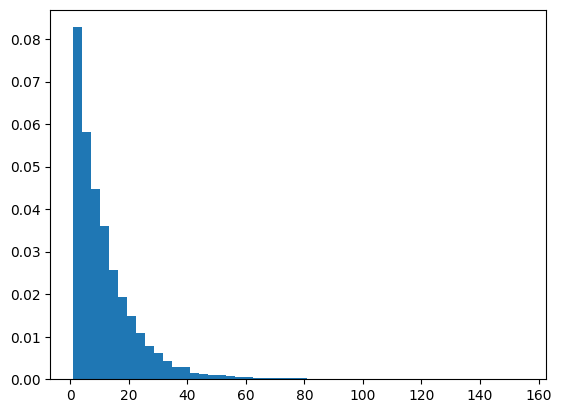

In [ ]:
# plt.hist(sent_len, density=True, bins=50)
# plt.plot()

In [ ]:
# sent_len.sort()
# cutoff_val = 40
# cutoff_idx = next(x[0] for x in enumerate(sent_len) if x[1] > cutoff_val)
# perc_sent_fewer_words_cutoff_val = cutoff_idx/len(sent_len)
# perc_sent_fewer_words_cutoff_val

0.9723043676069154

#### Data Preprocessing for Fine Tuning a Distilbert NN

In [20]:
kt.text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [21]:
trn, val, preproc = kt.text.texts_from_df(df, 'dialog', # name of column containing review text
                                          label_columns=['pony'], maxlen=100, max_features=50000,
                                          preprocess_mode='distilbert', val_pct=0.2)

['Apple Bloom', 'Applejack', 'Discord', 'Fluttershy', 'Pinkie Pie', 'Rainbow Dash', 'Rarity', 'Scootaloo', 'Spike', 'Starlight Glimmer', 'Sweetie Belle', 'Twilight Sparkle']
       Apple Bloom  Applejack  Discord  Fluttershy  Pinkie Pie  Rainbow Dash  \
index                                                                          
10774          0.0        0.0      0.0         0.0         0.0           0.0   
17505          0.0        0.0      0.0         0.0         0.0           0.0   
975            0.0        0.0      0.0         0.0         0.0           0.0   
21190          0.0        0.0      0.0         0.0         0.0           1.0   
34092          0.0        0.0      0.0         0.0         0.0           0.0   

       Rarity  Scootaloo  Spike  Starlight Glimmer  Sweetie Belle  \
index                                                               
10774     0.0        1.0    0.0                0.0            0.0   
17505     0.0        0.0    0.0                0.0        

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 13
	95percentile : 35
	99percentile : 59


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 35
	99percentile : 57


#### Build Model

In [22]:
model = kt.text.text_classifier('distilbert', train_data=trn, preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


In [23]:
learner = kt.get_learner(model, train_data=trn, val_data=val, batch_size=16) # default batch size = 32
# https://arxiv.org/abs/1609.04836 : Larger batch size leads to degradation in model ability to generalize

In [ ]:
# class_weights = dict(df_train["emotion_chatgpt"].value_counts()/len(df_train))
# class_weights = dict((encoding[key], value) for (key, value) in class_weights.items())

In [24]:
learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1256/1256 [==============================] - 232s 171ms/step - loss: 2.3477 - accuracy: 0.1870
Epoch 2/2
1256/1256 [==============================] - 170s 131ms/step - loss: 557.8198 - accuracy: 0.1695


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 1.44E-05
	Min numerical gradient (purple): 3.83E-05
	Min loss divided by 10 (omitted from plot): 1.00E-04


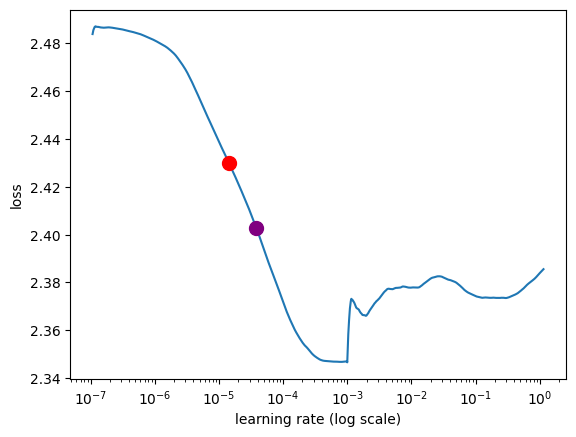

In [25]:
learner.lr_plot(suggest=True)

In [26]:
eps = 5
lr_opt = 1e-4 # for emotions_chatgpt

In [27]:
history = learner.autofit(lr=lr_opt, epochs=eps, checkpoint_folder="checkpoints")



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/5
1256/1256 [==============================] - 252s 190ms/step - loss: 2.1305 - accuracy: 0.2895 - val_loss: 1.9701 - val_accuracy: 0.3491
Epoch 2/5
1256/1256 [==============================] - 238s 190ms/step - loss: 1.8381 - accuracy: 0.3976 - val_loss: 1.9076 - val_accuracy: 0.3682
Epoch 3/5
1256/1256 [==============================] - 240s 191ms/step - loss: 1.5892 - accuracy: 0.4754 - val_loss: 1.9515 - val_accuracy: 0.3690
Epoch 4/5
1256/1256 [==============================] - 240s 191ms/step - loss: 1.3276 - accuracy: 0.5659 - val_loss: 2.0441 - val_accuracy: 0.3635
Epoch 5/5
1256/1256 [==============================] - 240s 191ms/step - loss: 1.0761 - accuracy: 0.6482 - val_loss: 2.1993 - val_accuracy: 0.3645


<ipython-input-28-c6aa912d2c03>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["accuracy"], 'b', label='Training', color="blue")
<ipython-input-28-c6aa912d2c03>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["val_accuracy"], 'b', label='Validation', color="orange")
<ipython-input-28-c6aa912d2c03>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["loss"], 'b', label='Training', color="blue")
<ipython-input-28-c6aa912d2c03>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string

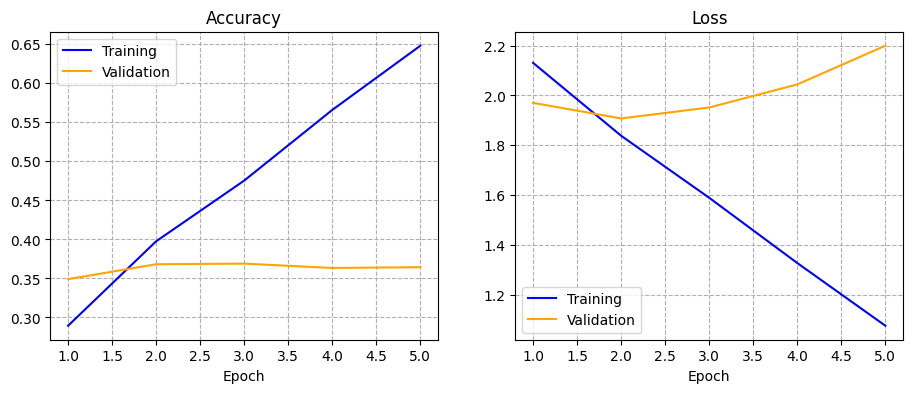

In [28]:
eps_ = range(1, eps+1)

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.grid(True, "both", linestyle="--")
plt.plot(eps_, history.history["accuracy"], 'b', label='Training', color="blue")
plt.plot(eps_, history.history["val_accuracy"], 'b', label='Validation', color="orange")
plt.title('Accuracy')
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(eps_, history.history["loss"], 'b', label='Training', color="blue")
plt.plot(eps_, history.history["val_loss"], 'b', label='Validation', color="orange")
plt.title('Loss')
plt.xlabel("Epoch")
plt.legend()

#### Make Predictions on Total Data

In [29]:
classifier = kt.get_predictor(model, preproc)

In [30]:
y_pred = classifier.predict(df['dialog'].to_list())